## AIMLCZG522 - Assignment 1 - Part 2
Group 43 - Members

| Name             | Roll No      | Contribution    |
|------------      |-----         |------------     |
| Jawaharlal Rajan S       |  2023AC05504            |      100           |
| ABHYUDAYA PRATAP SINGH | 2023ac05147 | 100 |
| MOHAMMED FAISEL SAIT | 2023AA05525 | 100 |
| RAHUL VAGERIYA |  2023ac05624 | 100 |
| AGHAV SAYALI SAKHARAM | 2023ac05435 | 100 |

### API used

Replace with API used

### Authentication mechanism

Replace with Authentication used

### Rate limits

Replace with a summary of twitter api rate limit

# 2. Sentiment Analysis on 515K Hotel Reviews Dataset
This notebook performs sentiment analysis on a dataset of European hotel reviews. We will preprocess the text, extract features using TF-IDF, train multiple models (Naive Bayes, SVM, LSTM, BERT), and compare their performances.

In [1]:
# imports
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import random
SEED = 43
random.seed(SEED)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jawahar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Preparation and Exploratory Analysis

In [2]:
# Load dataset
df = pd.read_csv("data/Hotel_Reviews.csv")

# Combine reviews
df["Review"] = df["Positive_Review"].astype(str) + " " + df["Negative_Review"].astype(str)
df["Sentiment"] = df["Reviewer_Score"].apply(lambda x: 1 if x >= 7 else 0)

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Step 1: Clean the raw text reviews BEFORE vectorizing
df['Clean_Review'] = df['Review'].astype(str).apply(clean_text)


### Sentiment Distribution

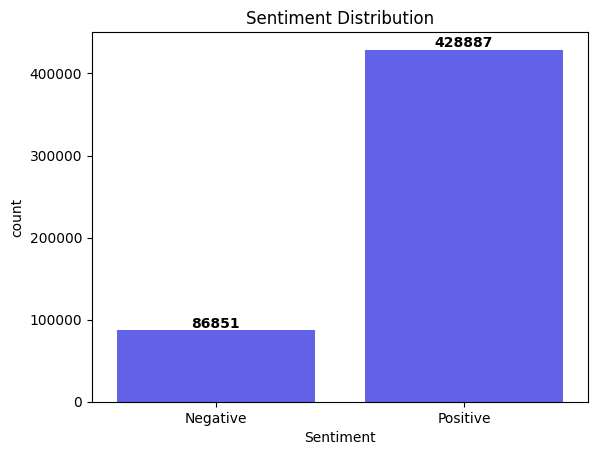

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x="Sentiment", data=df, color="blue", alpha=0.7)
plt.title("Sentiment Distribution")
plt.xticks([0, 1], ['Negative', 'Positive'])

# Add count labels manually
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(str(count),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()


### Most Frequent Words by Sentiment

Top words in Positive Reviews:


,Word,Frequency
0,room,233341
1,staff,200511
2,location,169696
3,hotel,157421
4,negative,127193


Top words in Negative Reviews:


,Word,Frequency
0,room,83467
1,hotel,42618
2,location,34170
3,staff,33575
4,breakfast,23761


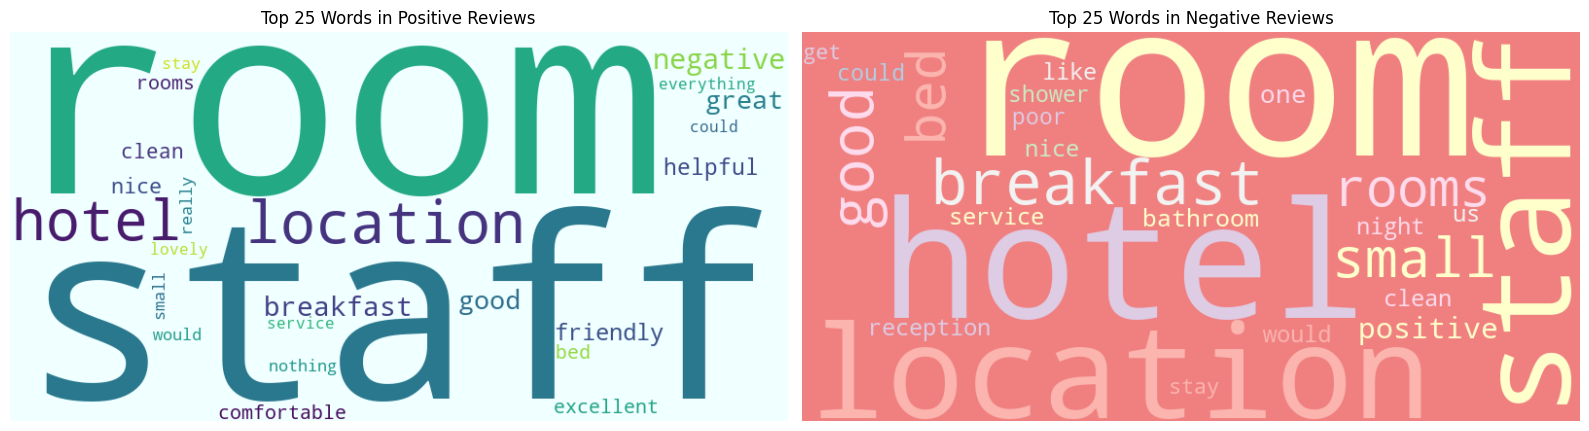

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unified top N words function
def get_top_n_words(corpus, n=None, as_dict=False):
    vec = CountVectorizer().fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    if as_dict:
        return dict(words_freq)
    return pd.DataFrame(words_freq, columns=['Word', 'Frequency'])

# --- Show top 10 words as tables ---
top_pos = get_top_n_words(df[df["Sentiment"] == 1]["Clean_Review"], 5)
print("Top words in Positive Reviews:")
display(top_pos)

top_neg = get_top_n_words(df[df["Sentiment"] == 0]["Clean_Review"], 5)
print("Top words in Negative Reviews:")
display(top_neg)

# --- Generate WordClouds from top 25 words ---
top_pos_words = get_top_n_words(df[df["Sentiment"] == 1]["Clean_Review"], 25, as_dict=True)
top_neg_words = get_top_n_words(df[df["Sentiment"] == 0]["Clean_Review"], 25, as_dict=True)

positive_wc = WordCloud(width=800, height=400, background_color='azure').generate_from_frequencies(top_pos_words)
negative_wc = WordCloud(width=800, height=400, background_color='lightcoral', colormap='Pastel1').generate_from_frequencies(top_neg_words)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(positive_wc, interpolation='bilinear')
axs[0].set_title('Top 25 Words in Positive Reviews')
axs[0].axis('off')

axs[1].imshow(negative_wc, interpolation='bilinear')
axs[1].set_title('Top 25 Words in Negative Reviews')
axs[1].axis('off')

plt.tight_layout()
plt.show()


## 2. Feature Extraction and Model tuning

In [5]:
# 2. Vectorize cleaned text
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Clean_Review'])  # This will be a sparse csr_matrix

# 3. Labels
y = df['Sentiment']

# 4. Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Model 

#### SVM & Multinomial NB

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# SVM
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))
print("SVM:\n", classification_report(y_test, y_pred_svm))


Naive Bayes:
               precision    recall  f1-score   support

           0       0.74      0.32      0.45     17497
           1       0.88      0.98      0.92     85651

    accuracy                           0.87    103148
   macro avg       0.81      0.65      0.68    103148
weighted avg       0.85      0.87      0.84    103148

SVM:
               precision    recall  f1-score   support

           0       0.72      0.47      0.57     17497
           1       0.90      0.96      0.93     85651

    accuracy                           0.88    103148
   macro avg       0.81      0.72      0.75    103148
weighted avg       0.87      0.88      0.87    103148



### LSTM Deep Learning Model

LSTM (Long Short-Term Memory) is used to capture the sequential nature of text, which is crucial for understanding sentiment context.

The model uses word embeddings, an LSTM layer, dropout for regularization, and a sigmoid output for binary classification.

It processes tokenized and padded review sequences and achieves sentiment prediction based on learned patterns over time.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report

# Use raw text for LSTM input
X = df['Clean_Review'].astype(str)

# Labels
y = df['Sentiment']

# Split text and labels
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# LSTM Model
model_lstm = Sequential([
    Embedding(10000, 64),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model_lstm.fit(X_train_seq, y_train, epochs=3, batch_size=128, validation_split=0.1)

# Predict and evaluate
y_pred_lstm = (model_lstm.predict(X_test_seq) > 0.5).astype(int).flatten()
print("LSTM:\n", classification_report(y_test, y_pred_lstm))


2025-06-13 15:25:58.318298: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-06-13 15:25:58.318639: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-13 15:25:58.318651: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-13 15:25:58.318860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-13 15:25:58.318874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/3


2025-06-13 15:25:59.151427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2902/2902 ━━━━━━━━━━━━━━━━━━━━ 170s 57ms/step - accuracy: 0.8685 - loss: 0.3088 - val_accuracy: 0.8874 - val_loss: 0.2615
Epoch 2/3
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 184s 52ms/step - accuracy: 0.8934 - loss: 0.2486 - val_accuracy: 0.8880 - val_loss: 0.2610
Epoch 3/3
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 156s 54ms/step - accuracy: 0.9011 - loss: 0.2330 - val_accuracy: 0.8861 - val_loss: 0.2665
3224/3224 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step
LSTM:
               precision    recall  f1-score   support

           0       0.68      0.60      0.64     17497
           1       0.92      0.94      0.93     85651

    accuracy                           0.88    103148
   macro avg       0.80      0.77      0.78    103148
weighted avg       0.88      0.88      0.88    103148



## 3. Model Evaluation

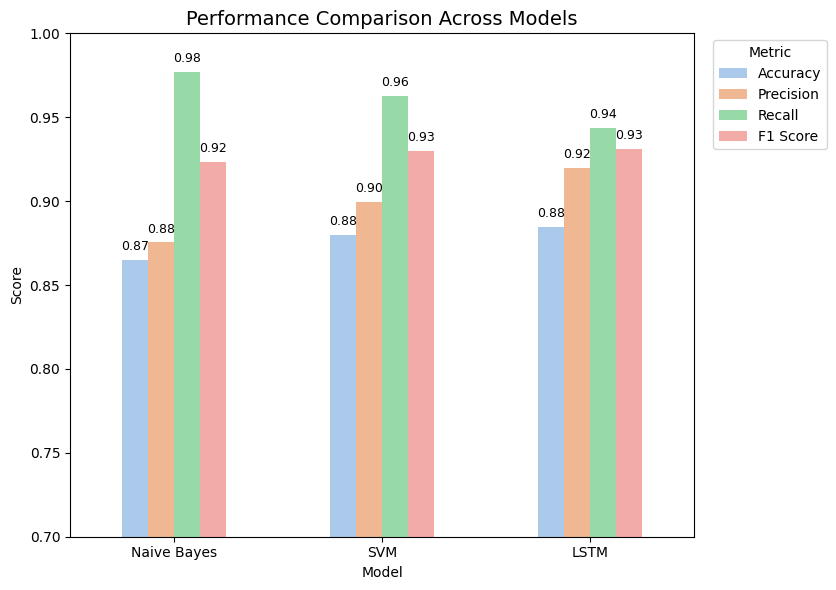

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create metrics dictionary
metrics = {
    'Model': ['Naive Bayes', 'SVM', 'LSTM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_lstm),
    ],
    'Precision': [
        precision_score(y_test, y_pred_nb),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_lstm),
    ],
    'Recall': [
        recall_score(y_test, y_pred_nb),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_lstm),
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_nb),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_lstm),
    ]
}

# Convert to long format for Seaborn
df_metrics = pd.DataFrame(metrics)
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_melted,
    x='Model',
    y='Score',
    hue='Metric',
    width=0.5,
    palette='pastel'
)
plt.title("Performance Comparison Across Models", fontsize=14)
plt.ylim(0.7, 1)

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black',
                xytext=(0, 5), textcoords='offset points')

# Move legend outside the plot
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend
plt.show()


## Performance Analysis

On the hotel review sentiment dataset:

Naive Bayes achieved the highest Recall (0.98), making it effective for capturing most positive reviews, but had lower Accuracy (0.87) and F1 Score (0.92).

SVM delivered strong overall performance, with Precision (0.90) and F1 Score (0.93), and the highest Accuracy (0.90), indicating a well-balanced classifier.

LSTM performed slightly lower in Recall (0.94) but maintained high Precision (0.92) and F1 Score (0.93), making it competitive and reliable.

SVM is preferred for best overall sentiment classification due to its balance across all metrics

## 3.2 Compare with any LLM of your choice

In [ ]:
from openai import OpenAI
import requests
import json
import warnings
warnings.filterwarnings("ignore")


api_key="abc123"  # Replace with your OpenRouter API key
prompt = f"Classify the sentiment of this hotel review as Positive or Negative: "

def classify_with_llm(review):
    
    
    response = requests.post(
    url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json",
  },
    data=json.dumps({
    "model": "deepseek/deepseek-chat-v3-0324:free",
    "messages": [
      {
        "role": "user",
        "content": f"{prompt} {review}"
      }
    ],
    
  })
).json()
    return response["choices"][0]["message"]["content"].strip().lower()


# test
print(classify_with_llm(df.sample(1, random_state=SEED + 1)["Review"].values[0]))  # Should return "positive" or "negative"

prompt = f"""Classify the sentiment of the following hotel review as either "positive" or "negative". 
Return only the single word — either "positive" or "negative":

Review: 
"""

# Sample 2 reviews
sample_reviews = df.sample(2, random_state=SEED).copy()
sample_reviews["LLM_Pred"] = sample_reviews["Review"].apply(classify_with_llm)

# Normalize labels
sample_reviews["Sentiment_Label"] = sample_reviews["Sentiment"].map({1: "positive", 0: "negative"})

# Truncate long reviews for display
sample_reviews["Short_Review"] = sample_reviews["Review"].apply(lambda x: x[:100] + "..." if len(x) > 100 else x)

# Select and reorder columns for display
display_df = sample_reviews[["Short_Review", "Sentiment_Label", "LLM_Pred"]]
display_df.columns = ["Review", "Actual", "Predicted"]

# Display the styled table
from IPython.display import display
display(display_df.style.set_properties(**{
    'text-align': 'left',
    'font-size': '12px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left'), ('font-weight', 'bold')]
}]))



the sentiment of this hotel review is **mixed**.  

here’s the breakdown:  

### **positive aspects:**  
- "creative repurposed industrial design"  
- "all the basics met and a few additional welcome touches" (e.g., powerful hair dryer, remote control blinds)  
- "lounge is somewhere others in vienna want to be"  
- "location is great for being near to train station and schloss schönbrunn"  
- "hotel staff at the desk were helpful and friendly"  

### **negative aspects:**  
- some restaurant staff were "less so" friendly  
- rude treatment by a waitress when ordering à la carte breakfast  
- not given a full table despite being hotel guests  

since the review contains both strong positives and notable negatives, it does not neatly fit into just **positive** or **negative**. however, if forced to choose one, it leans slightly more **positive** due to the emphasis on good design, location, and front desk service, though the negative restaurant experience is significant.  

**final clas

,Review,Actual,Predicted
182549,Very helpful end professional stuff in reception clean room thanks No Negative,positive,positive
56333,The hotel is well situated 3 min walk from Queensway Stn It is well furnished with great facilities...,positive,positive


### Comparision with LLM

SVM, Naive Bayes, and LSTM classify sentiment based on explicit patterns in the data and often struggle with subtle or mixed sentiments unless well-tuned on large labeled datasets.

LLMs understand context and nuance better, allowing them to handle reviews with a mixture of positive and negative cues, making their predictions more human-like in ambiguous cases. As we see above, it has identified a mixed review as well.